In [1]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
import pandas as pd# Added
from IPython.display import Audio
from sklearn.externals import joblib

In [2]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

In [3]:
# Specify where the audio files for training and testing reside
train_folder = './train'
test_folder = './test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'abscent'
label1 = 'present'
labels = [label0, label1]

In [4]:
# Make 1 second summarization as features with half second of hop length
# 172 frames == 1 second (using 44100 samples per second)
# 166 frames ~ 0.96 second
feature_length = 96
half_sec = 48

In [5]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in train_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0][48:] # VGGish starts from 0.48 second
    
    #print (vggish)
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    print (vggish.shape[0]/half_sec)
    
    for chunk in range(int(vggish.shape[0]/half_sec)):
        start = chunk*half_sec
        vggish_means = np.mean(vggish[start:start+feature_length, :], 0)
        vggish_stddevs = np.std(vggish[start:start+feature_length, :], 0)
        #print (vggish_means.shape, start, start+feature_length)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(np.concatenate((vggish_means, vggish_stddevs), axis=0))
        #print (np.concatenate((vggish_means, vggish_stddevs), axis=0))
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec/2:
            tf_label.append('present')
        else:
            tf_label.append('abscent')

    # Get labels index
    tf_label_ind = [labels.index(lbl) for lbl in tf_label]
    print("file label size: {:d}".format(len(tf_label_ind)))
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        train_labels.append(tf_label_ind[idx]) 
    print(" ")

filename: CroqueMadame_Pilot_MIX.wav
1001.3541666666666
file label size: 1001
 
filename: StevenClark_Bounty_MIX.wav
601.0208333333334
file label size: 601
 
filename: HezekiahJones_BorrowedHeart_MIX.wav
501.2708333333333
file label size: 501
 
filename: TheDistricts_Vermont_MIX.wav
473.2916666666667
file label size: 473
 
filename: NightPanther_Fire_MIX.wav
441.7291666666667
file label size: 441
 
filename: ClaraBerryAndWooldog_WaltzForMyVictims_MIX.wav
363.4583333333333
file label size: 363
 
filename: MusicDelta_80sRock_MIX.wav
74.89583333333333
file label size: 74
 
filename: Auctioneer_OurFutureFaces_MIX.wav
431.0625
file label size: 431
 
filename: EthanHein_GirlOnABridge_MIX.wav
268.9583333333333
file label size: 268
 
filename: MusicDelta_Rockabilly_MIX.wav
52.041666666666664
file label size: 52
 
filename: SecretMountains_HighHorse_MIX.wav
738.6041666666666
file label size: 738
 
filename: ClaraBerryAndWooldog_Stella_MIX.wav
405.7708333333333
file label size: 405
 
filename: L

In [6]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0][48:] # VGGish starts from 0
    
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    print (vggish.shape[0])
    
    for chunk in range(int(vggish.shape[0]/half_sec)):
        start = chunk*half_sec
        vggish_means = np.mean(vggish[start:start+feature_length, :], 0)
        vggish_stddevs = np.std(vggish[start:start+feature_length, :], 0)
        #print (vggish_means.shape, start, start+feature_length)
    
        # Concatenate means and std. dev's into a single feature vector
        feature_vector.append(np.concatenate((vggish_means, vggish_stddevs), axis=0))
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) > half_sec/2:
            tf_label.append('present')
        else:
            tf_label.append('abscent')
    
    #Get labels index
    tf_label_ind = np.array([labels.index(lbl) for lbl in tf_label])
    print("file label size: {}".format(tf_label_ind.shape))
    
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        test_features.append(feature_vector[idx])
        test_labels.append(tf_label_ind[idx])
    print(" ")

filename: MusicDelta_InTheHalloftheMountainKing_MIX.wav
1647
file label size: (34,)
 
filename: MusicDelta_GriegTrolltog_MIX.wav
6753
file label size: (140,)
 
filename: Mozart_BesterJungling_MIX.wav
17317
file label size: (360,)
 
filename: Handel_TornamiAVagheggiar_MIX.wav
22203
file label size: (462,)
 
filename: MatthewEntwistle_Lontano_MIX.wav
29703
file label size: (618,)
 
filename: AmarLal_SpringDay1_MIX.wav
13295
file label size: (276,)
 
filename: MusicDelta_Country2_MIX.wav
1648
file label size: (34,)
 
filename: Grants_PunchDrunk_MIX.wav
20363
file label size: (424,)
 
filename: ChrisJacoby_PigsFoot_MIX.wav
36614
file label size: (762,)
 
filename: MusicDelta_Grunge_MIX.wav
4088
file label size: (85,)
 
filename: MatthewEntwistle_DontYouEver_MIX.wav
11305
file label size: (235,)
 
filename: MusicDelta_Country1_MIX.wav
3377
file label size: (70,)
 
filename: Lushlife_ToynbeeSuite_MIX.wav
62759
file label size: (1307,)
 
filename: SweetLights_YouLetMeDown_MIX.wav
39101
file l

In [7]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)

In [8]:
test_features_scaled = scaler.transform(test_features)

# Note, the first 2 operations (learning the standardization parameters from the training data 
# and applying them to the the training data) can be performed in one line using:
# train_features_scaled = scaler.fit_transform(train_features)

In [9]:
# save the scaler to disk
filename = 'scaler_VGGish.sav'
joblib.dump(scaler, filename)

['scaler_VGGish.sav']

<h2> Step 3: model training</h2>

Now that all of our features are computed, we can train a clasification model! In this example we're going to use the following model: the support vector machine classifier. 

In [23]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a SVC with default parameters: kernel RBF 
clf = sklearn.svm.SVC()

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
# save the model to disk
filename = 'finalized_model_VGGish.sav'
joblib.dump(clf, filename)

['finalized_model_VGGish.sav']

In [27]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

In [28]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.825006516639


In [29]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[4954 1360]
 [ 654 4541]]


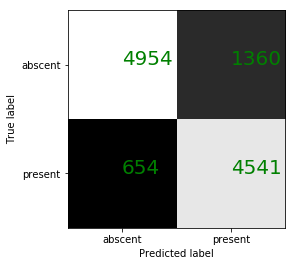

In [31]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

### Random Forest Classifier without scaler

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators=500)

# Fit (=train) the model
clf3.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

<h2>Step 4: model evaluation Random Forest Classifier (testing)</h2>

In [33]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(test_features)

<h3>Model accuracy</h3>

In [34]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.823008080633


<h3>Confusion matrix</h3>

In [35]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[4966 1348]
 [ 689 4506]]


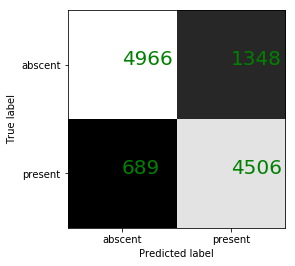

In [36]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()